In [1]:
# #############################################################################
# Sample Program
# 2024.05.31

# Program
#     to estimate core ABP values (DBP/SBP/MAP) based on PPG signals using Tansformer Emcoder model
#     tp generate ABP waves based on U-Net

- Adjustment

In [1]:
# DBP/SBP/MAP Normaization
abp_data_min = 20
abp_data_max = 200
abp_normalized_min = 0
abp_normalized_max = 1

# Cutoff frequency of lowpass filter
cutoff_high = 12
SAMPLING_RATE = 125

- Normailzation Function

In [21]:
import numpy as np

def normalize_data(data, data_min, data_max, normalized_min, normalized_max):
    if data_min == data_max:
        print("Error: Data minimum and maximum values are equal.")
        return None

    if normalized_min >= normalized_max:
        print("Error: Normalization range is invalid.")
        return None

    # 데이터를 normalized_min 에서 normalized_max 로 정규화합니다.
    normalized_data = normalized_min + (data - data_min) * ((normalized_max - normalized_min) / (data_max - data_min))
    return normalized_data

def denormalize_data(normalized_data, data_min, data_max, normalized_min, normalized_max):
    if normalized_min >= normalized_max:
        print("Error: Normalization range is invalid.")
        return None

    if normalized_data is None:
        print("Error: Normalized data is None.")
        return None

    # 정규화된 데이터를 다시 원래 데이터로 복원합니다.
    data = ((normalized_data - normalized_min) * (data_max - data_min) / (normalized_max - normalized_min)) + data_min
    return data

# min/max ormalization
def minmax_normalize(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    normalized_signal = (signal - min_val) / (max_val - min_val)
    return normalized_signal, min_val, max_val

# restoring function
def minmax_restore(normalized_signal, min_val, max_val):
    original_signal = normalized_signal * (max_val - min_val) + min_val
    return original_signal

# normalized_ppg = normalize_data(ppg_sample, ppg_data_min, ppg_data_max, ppg_normalized_min, ppg_normalized_max)
# restored_ppg = denormalize_data(normalized_ppg, ppg_data_min, ppg_data_max, ppg_normalized_min, ppg_normalized_max)

- Filtering Function


In [5]:
from scipy import signal
from scipy.signal import butter, filtfilt

def apply_band_pass_filter(data, lowcut, highcut, sampling_frequency, order=4, padlen=None):
    nyquist_frequency = 0.5 * sampling_frequency
    low = lowcut / nyquist_frequency
    high = highcut / nyquist_frequency

    b, a = butter(order, [low, high], btype='band', analog=False)

    if padlen is not None:
        f_data = filtfilt(b, a, data, padlen=padlen)
    else:
        f_data = filtfilt(b, a, data)

    return f_data

# usage:
# cutoff_low = 0.5  # 저주파 컷오프
# cutoff_high = 12.0  # 고주파 컷오프
# filtered_signal = apply_band_pass_filter(data, cutoff_low, cutoff_high, SAMPLING_RATE)


def apply_low_pass_filter(data, cutoff, sampling_frequency, order=4, padlen=None):
    nyquist_frequency = 0.5 * sampling_frequency
    normalized_cutoff = cutoff / nyquist_frequency

    b, a = butter(order, normalized_cutoff, btype='low', analog=False)

    if padlen is not None:
        f_data = filtfilt(b, a, data, padlen=padlen)
    else:
        f_data = filtfilt(b, a, data)

    return f_data

# usage example:
# cutoff = 12.0  # Cutoff frequency in Hz
# filtered_signal = apply_low_pass_filter(data, cutoff, SAMPLING_RATE)

In [19]:
import tensorflow as tf
abp_model = tf.keras.models.load_model('ABP_model_tf')
wave_model = tf.keras.models.load_model('wave_model_tf')

# get abp values ([DBP SBP MAP]) for given one segment ppg signals

def one_seg_abp (x2_seg) :
    predict_result = abp_model.predict(np.reshape(x2_seg, (1, 1024)), verbose=0)
    predict_result = np.array(predict_result)
    predict_result = predict_result.reshape(-1)

    predict_abp  = denormalize_data(predict_result, abp_data_min, abp_data_max, abp_normalized_min, abp_normalized_max)

    return predict_abp

# get abp values when given one-segment PPG signals (1024 size)

def one_seg_wave (x2_seg) :
    results = wave_model.predict(np.reshape(x2_seg, (1, 1024)), verbose=0)
    results = np.array(results)
    predictions = tf.squeeze(results, axis=-1)

    predict_wave = predictions [0]

    return np.array(predict_wave)


In [8]:
import numpy as np

# load sample ppg data
filename = "x2_ppg.npy"
ppg_data = np.load(filename)
print(ppg_data.shape)

(100, 1024)


In [9]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def seg_display (abp_wave) :
        plt.figure(figsize=(12, 4))

        plt.plot(abp_wave, color = 'r' )

        # x축과 y축 눈금 표시하지 않음
        plt.xticks([])
        plt.yticks([])

        # 외곽 사각형 박스 그리지 않음
        # plt.box(False)

        clear_output(wait=True)

        plt.show()

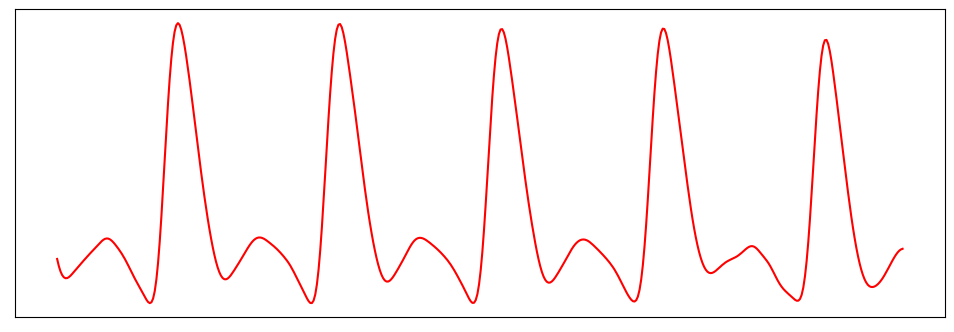

[DBP SBP MAP] = [ 48 101  65]
KeyboardInterrupt occurred


In [22]:
import time
try:
    # process test data
    i = 0
    while i < ppg_data.shape[0]:    # ppg_data = (100, 1024)
        #####: Arrange input ppg data
        start_time = time.time()
        ppg = ppg_data[i]     # for ABP values  (Transformer Encoder)
        normalized_ppg, min_val, max_val = minmax_normalize(ppg)   # for ABP waves (U-Net)
        
        #####: Generate ABP Waves
        abp_wave = one_seg_wave ( normalized_ppg )
        abp_wave = apply_low_pass_filter(abp_wave, cutoff_high, SAMPLING_RATE)
        fixed_abp_wave = abp_wave[256:-256]     # 512 output size for 1024 input size
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")

        #####: Estimate ABP values
        start_time = time.time()
        abp_values = one_seg_abp( ppg )
        abp_values = np.round(abp_values).astype(int)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")
        
        #####: Show
        seg_display (fixed_abp_wave)
        print ("[DBP SBP MAP] =", abp_values)

        # time.sleep(1)

        i=i+1

    print ("Done:")

except KeyboardInterrupt:
    print("KeyboardInterrupt occurred")
